# **05 INTERPRETABILITY**

In [3]:
from pathlib import Path
import sys

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns  

from scipy.stats import randint, uniform, loguniform
from statsmodels.tsa.seasonal import seasonal_decompose
from category_encoders import *


from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.model_selection import (
    train_test_split,
    cross_validate,
    RandomizedSearchCV,
    StratifiedKFold,
    KFold,
    cross_val_score
)
from sklearn.preprocessing import (
    StandardScaler,
    OneHotEncoder,
    OrdinalEncoder,
    FunctionTransformer,
)
from sklearn.feature_selection import SelectKBest
from sklearn.linear_model import LinearRegression, Ridge, ElasticNet
from sklearn.ensemble import (
    RandomForestRegressor,
    GradientBoostingRegressor,
    HistGradientBoostingRegressor,
    ExtraTreesRegressor
)
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.metrics import (
    mean_squared_error,
    mean_absolute_error,
    r2_score,
)
from sklearn.dummy import DummyRegressor

# ——— Additional models ————————————————————————
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from catboost import CatBoostRegressor

import warnings
warnings.filterwarnings('ignore')



In [4]:


# Project root & data paths
project_root = Path().resolve()
df_pre_path = project_root / "data" / "interim" / "data_preprocessed.parquet"

# Print the path to verify it exists
print(f"Looking for file at: {df_pre_path}")

# Check if file exists before reading
if not df_pre_path.exists():
	# Try alternate path
	df_pre_path = project_root.parent / "data" / "interim" / "data_preprocessed.parquet"
	print(f"Alternate path: {df_pre_path}")

if df_pre_path.exists():
	df = pd.read_parquet(df_pre_path)
	print("Successfully loaded the dataset")
else:
	raise FileNotFoundError(f"Could not find the parquet file at {df_pre_path}")

src_path = project_root / "src"
if src_path.exists():
	sys.path.append(str(src_path))


Looking for file at: /Users/stellaandorno/Desktop/github_public/airbnb_milan/notebooks/data/interim/data_preprocessed.parquet
Alternate path: /Users/stellaandorno/Desktop/github_public/airbnb_milan/data/interim/data_preprocessed.parquet
Successfully loaded the dataset


First thing, I remove outliers in the target variable price, and I log-transform it.

In [5]:
# 1. First, examine your price_per_person distribution BEFORE any processing
df["price_per_person"] = df["price"] / df["accommodates"]

# Check for extreme values
print("Price per person statistics:")
print(df["price_per_person"].describe())
print(f"Values above €1000 per person: {(df['price_per_person'] > 1000).sum()}")
print(f"Values above €500 per person: {(df['price_per_person'] > 500).sum()}")

# 2. Create a reasonable filter for price per person
# Most Airbnb prices per person should be between €10-300 per night
reasonable_mask = (df["price_per_person"] >= 10) & (df["price_per_person"] <= 500)
df_filtered = df[reasonable_mask].copy()

print(f"Removed {len(df) - len(df_filtered)} extreme outliers")

# 3. Now proceed with your train/test split on the filtered data
X = df_filtered.drop(columns=["price", "price_per_person"])
y = df_filtered["price_per_person"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# 4. Apply IQR outlier removal to training set only
Q1 = y_train.quantile(0.25)
Q3 = y_train.quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

train_mask = (y_train >= lower_bound) & (y_train <= upper_bound)
X_train_clean = X_train[train_mask]
y_train_clean = y_train[train_mask]

# 5. Log transform
y_train_log = np.log1p(y_train_clean)
y_test_log = np.log1p(y_test)

Price per person statistics:
count    21961.000000
mean        73.041143
std        432.687976
min          3.000000
25%         31.250000
50%         45.000000
75%         68.500000
max      44444.000000
Name: price_per_person, dtype: float64
Values above €1000 per person: 77
Values above €500 per person: 117
Removed 154 extreme outliers


In [6]:
"""# 1. Split FIRST on raw data to avoid data leakage
X = df.drop(columns=["price"])

# Create price_per_person target
df["price_per_person"] = df["price"] / df["accommodates"]
y = df["price_per_person"]

# Train-test split BEFORE outlier removal
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Remove outliers only from training set
Q1 = y_train.quantile(0.25)  # Only training data
Q3 = y_train.quantile(0.75)  # Only training data
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Apply to training set only
train_mask = (y_train >= lower_bound) & (y_train <= upper_bound)
X_train = X_train[train_mask]
y_train = y_train[train_mask]

# Log-transform after outlier removal
y_train_log = np.log1p(y_train)
y_test_log = np.log1p(y_test)  # Transform test, but don't remove outliers"""

'# 1. Split FIRST on raw data to avoid data leakage\nX = df.drop(columns=["price"])\n\n# Create price_per_person target\ndf["price_per_person"] = df["price"] / df["accommodates"]\ny = df["price_per_person"]\n\n# Train-test split BEFORE outlier removal\nX_train, X_test, y_train, y_test = train_test_split(\n    X, y, test_size=0.2, random_state=42\n)\n\n# Remove outliers only from training set\nQ1 = y_train.quantile(0.25)  # Only training data\nQ3 = y_train.quantile(0.75)  # Only training data\nIQR = Q3 - Q1\n\nlower_bound = Q1 - 1.5 * IQR\nupper_bound = Q3 + 1.5 * IQR\n\n# Apply to training set only\ntrain_mask = (y_train >= lower_bound) & (y_train <= upper_bound)\nX_train = X_train[train_mask]\ny_train = y_train[train_mask]\n\n# Log-transform after outlier removal\ny_train_log = np.log1p(y_train)\ny_test_log = np.log1p(y_test)  # Transform test, but don\'t remove outliers'

I now recall the features in their respective categories in order to be able to feed them to the pipeline, recalling what I did in the previous notebooks.

In [7]:


# 4. Define feature groups
numeric_features = [
    'host_listings_count', 'host_total_listings_count', 'bathrooms', 'bedrooms', 'beds',
    'minimum_nights_avg_ntm', 'maximum_nights_avg_ntm',
    'number_of_reviews', 'number_of_reviews_ltm', 'number_of_reviews_l30d',
    'calculated_host_listings_count',
    'calculated_host_listings_count_private_rooms',
    'reviews_per_month', 'days_since_host_since',
    'air_conditioning', 'elevator', 'fast_wifi', 'parking',
    'coffee_machine', 'washer', 'self_check_in', 'streaming_tv',
    'dedicated_workspace', 'private_entrance', 'kitchen_appliances',
    'heating', 'hot_water', 'safety_equipment', 'clothing_storage',
    'balcony', 'premium_views', 'dishwasher', 'gym'
]

categorical_features = [
    'neighbourhood_cleansed',
    'property_type',
    'room_type',
    'host_location'
]

ordinal_features_days = [
    'days_since_first_review',
    'days_since_last_review'
]

# I will keep just one since they are very correlated
ordinal_features_reviews = [
    'review_scores_rating',
    'review_scores_accuracy',
    'review_scores_cleanliness',
    'review_scores_checkin',
    'review_scores_communication',
    'review_scores_location',
    'review_scores_value']

ordinal_features = ordinal_features_days + ordinal_features_reviews

# 5. Define category orders for OrdinalEncoder
first_review_order = [
    'no_review_yet',
    'very_new (<= 1 month)',
    'new (<= 6 months)',
    'established (<= 1 year)',
    'mature (<= 3 years)',
    'veteran (<= 5 years)',
    'legacy (over 5 years)'
]

last_review_order = [
    'no_review',
    'very_recent (<= 1 week)',
    'recent (<= 1 month)',
    'somewhat_recent (<= 3 months)',
    'old (<= 6 months)',
    'very_old (<= 1 year)',
    'dormant (over a year)'
]


review_order = ["no_reviews", "low_reviews", "medium_reviews", "high_reviews", "top_reviews"]

all_ord_categories = (
    [first_review_order, last_review_order] +
    [review_order] * len(ordinal_features_reviews)
)



In [8]:
# 6. Build transformers
numeric_transformer = Pipeline([
    ("scaler", StandardScaler())
])

categorical_transformer = Pipeline([
    ("ohe", OneHotEncoder(handle_unknown="ignore"))
])

ordinal_transformer = Pipeline([
    ("ordinal", OrdinalEncoder(categories=all_ord_categories))
])

# 7. Combine into ColumnTransformer
preprocessor = ColumnTransformer(transformers=[
    ("num", numeric_transformer,   numeric_features),
    ("cat", categorical_transformer, categorical_features),
    ("ord", ordinal_transformer,    ordinal_features),
], remainder="drop")

# 8. Create full Pipeline
model_pipeline = Pipeline([
    ("preprocessor", preprocessor),
    ("select", SelectKBest(k=50)),
    ("regressor", RandomForestRegressor(random_state=42))
])

In [9]:
models_and_params = {


    'XGBoost': {
        'model': XGBRegressor(objective="reg:squarederror", n_jobs=-1, random_state=42),
        'params': {
            'regressor__n_estimators': randint(200, 1000),
            'regressor__max_depth': randint(4, 12),
            'regressor__learning_rate': loguniform(0.01, 0.3),
            'regressor__subsample': uniform(0.6, 0.4),
            'regressor__colsample_bytree': uniform(0.6, 0.4),
            'regressor__gamma': loguniform(1e-8, 1e-1),
            'select__k': randint(30, 120)
        }
    },
    
        }

### XGBOOST  

In [10]:
def nested_cross_validation_regression(X, y, models_and_params, outer_cv=5, inner_cv=3, 
                                     n_iter=20, scoring='r2', random_state=42):
    """
    Perform nested cross-validation for regression model selection and performance estimation.
    
    Parameters:
    -----------
    X : array-like, shape (n_samples, n_features)
        Feature matrix
    y : array-like, shape (n_samples,)
        Target vector
    models_and_params : dict
        Dictionary containing models and their hyperparameter grids
    outer_cv : int
        Number of folds for outer cross-validation
    inner_cv : int
        Number of folds for inner cross-validation (hyperparameter tuning)
    n_iter : int
        Number of parameter settings sampled for RandomizedSearchCV
    scoring : str
        Scoring metric
    random_state : int
        Random state for reproducibility
    
    Returns:
    --------
    results : dict
        Dictionary containing results for each model
    """
    
    # Initialize cross-validation splitters
    outer_cv_splitter = KFold(n_splits=outer_cv, shuffle=True, random_state=random_state)
    inner_cv_splitter = KFold(n_splits=inner_cv, shuffle=True, random_state=random_state)
    
    results = {}
    
    print("=== NESTED CROSS-VALIDATION FOR AIRBNB PRICE PREDICTION ===\n")
    print(f"Dataset shape: {X.shape}")
    print(f"Target range: {y.min():.3f} - {y.max():.3f} (log-transformed)")
    print(f"Outer CV: {outer_cv} folds, Inner CV: {inner_cv} folds")
    print(f"Hyperparameter search iterations: {n_iter}\n")
    
    for model_name, model_config in models_and_params.items():
        print(f"Evaluating {model_name}...")
        
        # Create pipeline with preprocessing, feature selection, and classifier
        pipeline = Pipeline([
            ('preprocessor', preprocessor),
            ('select', SelectKBest(k=50)),  # Default value, will be tuned if in params
            ('regressor', model_config['model'])
        ])
        
        # Outer loop: Performance estimation
        outer_scores = []
        best_params_per_fold = []
        
        fold = 1
        for train_idx, test_idx in outer_cv_splitter.split(X):
            print(f"  Processing outer fold {fold}/{outer_cv}")
            
            X_train_outer, X_test_outer = X.iloc[train_idx], X.iloc[test_idx]
            y_train_outer, y_test_outer = y.iloc[train_idx], y.iloc[test_idx]
            
            # Inner loop: Hyperparameter optimization
            if model_config['params']:  # Only tune if there are parameters to tune
                search = RandomizedSearchCV(
                    pipeline, 
                    model_config['params'],
                    cv=inner_cv_splitter,
                    scoring=scoring,
                    n_iter=n_iter,
                    n_jobs=-1,
                    random_state=random_state,
                    return_train_score=False
                )
                
                # Fit grid search on outer training set
                search.fit(X_train_outer, y_train_outer)
                
                # Get best model from inner CV
                best_model = search.best_estimator_
                best_params_per_fold.append(search.best_params_)
            else:
                # No hyperparameters to tune, just fit the pipeline
                pipeline.fit(X_train_outer, y_train_outer)
                best_model = pipeline
                best_params_per_fold.append({})
            
            # Evaluate best model on outer test set
            y_pred = best_model.predict(X_test_outer)
            if scoring == 'r2':
                fold_score = r2_score(y_test_outer, y_pred)
            elif scoring == 'neg_mean_squared_error':
                fold_score = -mean_squared_error(y_test_outer, y_pred)
            elif scoring == 'neg_mean_absolute_error':
                fold_score = -mean_absolute_error(y_test_outer, y_pred)
            else:
                fold_score = best_model.score(X_test_outer, y_test_outer)
            
            outer_scores.append(fold_score)
            fold += 1
        
        # Store results
        results[model_name] = {
            'outer_scores': outer_scores,
            'mean_score': np.mean(outer_scores),
            'std_score': np.std(outer_scores),
            'best_params_per_fold': best_params_per_fold
        }
        
        print(f"  Mean {scoring}: {np.mean(outer_scores):.4f} (+/- {np.std(outer_scores):.4f})")
        print(f"  Individual fold scores: {[f'{score:.4f}' for score in outer_scores]}")
        print()
    
    return results

def select_best_model_and_retrain(X, y, models_and_params, results, inner_cv=3, n_iter=50):
    """
    Select the best model based on nested CV results and retrain on full dataset.
    """
    # Find best model
    best_model_name = max(results.keys(), key=lambda k: results[k]['mean_score'])
    best_model_config = models_and_params[best_model_name]
    
    print(f"=== BEST MODEL SELECTION ===")
    print(f"Best model: {best_model_name}")
    print(f"Expected performance: {results[best_model_name]['mean_score']:.4f} "
          f"(+/- {results[best_model_name]['std_score']:.4f})")
    print()
    
    # Retrain best model on full dataset with hyperparameter tuning
    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('select', SelectKBest(k=50)),
        ('regressor', best_model_config['model'])
    ])
    
    if best_model_config['params']:
        inner_cv_splitter = KFold(n_splits=inner_cv, shuffle=True, random_state=42)
        
        final_search = RandomizedSearchCV(
            pipeline,
            best_model_config['params'],
            cv=inner_cv_splitter,
            scoring='r2',
            n_iter=n_iter,
            n_jobs=-1,
            random_state=42
        )
        
        final_search.fit(X, y)
        final_model = final_search.best_estimator_
        
        print(f"Final model hyperparameters: {final_search.best_params_}")
        print(f"Cross-validation score on full dataset: {final_search.best_score_:.4f}")
    else:
        pipeline.fit(X, y)
        final_model = pipeline
        print("No hyperparameters to tune for this model.")
    
    return final_model, best_model_name


In [11]:

print("Starting Nested Cross-Validation for Airbnb Price Prediction...")
print(f"Training set shape: {X_train.shape}")
print(f"Test set shape: {X_test.shape}")
print()

# Perform nested cross-validation (reduced subset for demonstration)
# You can include all models by using the full models_and_params dictionary
selected_models = models_and_params


cv_results = nested_cross_validation_regression(
    X_train, y_train, 
    selected_models,  # Use selected_models or models_and_params for all
    outer_cv=5, 
    inner_cv=3, 
    n_iter=20,  # Reduced for faster execution
    scoring='r2'
)

# Select and retrain best model
final_model, best_model_name = select_best_model_and_retrain(
    X_train, y_train, selected_models, cv_results, n_iter=30
)



Starting Nested Cross-Validation for Airbnb Price Prediction...
Training set shape: (17445, 55)
Test set shape: (4362, 55)

=== NESTED CROSS-VALIDATION FOR AIRBNB PRICE PREDICTION ===

Dataset shape: (17445, 55)
Target range: 10.000 - 500.000 (log-transformed)
Outer CV: 5 folds, Inner CV: 3 folds
Hyperparameter search iterations: 20

Evaluating XGBoost...
  Processing outer fold 1/5
  Processing outer fold 2/5
  Processing outer fold 3/5
  Processing outer fold 4/5
  Processing outer fold 5/5
  Mean r2: 0.2978 (+/- 0.0257)
  Individual fold scores: ['0.2581', '0.2768', '0.3250', '0.3141', '0.3148']

=== BEST MODEL SELECTION ===
Best model: XGBoost
Expected performance: 0.2978 (+/- 0.0257)

Final model hyperparameters: {'regressor__colsample_bytree': np.float64(0.8099025726528951), 'regressor__gamma': np.float64(1.0558813779064815e-05), 'regressor__learning_rate': np.float64(0.02692655251486473), 'regressor__max_depth': 6, 'regressor__n_estimators': 710, 'regressor__subsample': np.float

## FINAL EVALUATION ON TEST SET

In [12]:


print("\n=== FINAL TEST SET EVALUATION ===")
y_pred_test = final_model.predict(X_test)

# Calculate metrics on log-transformed data
test_r2 = r2_score(y_test_log, y_pred_test)
test_rmse = np.sqrt(mean_squared_error(y_test_log, y_pred_test))
test_mae = mean_absolute_error(y_test_log, y_pred_test)

print(f"Test R² (on log-transformed data): {test_r2:.4f}")
print(f"Test RMSE (on log-transformed data): {test_rmse:.4f}")
print(f"Test MAE (on log-transformed data): {test_mae:.4f}")

# Safely convert predictions back to original scale
try:
    # Clip predictions to avoid extreme values
    y_pred_clipped = np.clip(y_pred_test, 0, 10)  # Limit maximum log value
    y_pred_original = np.expm1(y_pred_clipped)
    y_test_actual = y_test  # Original non-logged values
    
    # Calculate metrics on original scale
    test_rmse_original = np.sqrt(mean_squared_error(y_test_actual, y_pred_original))
    test_mae_original = mean_absolute_error(y_test_actual, y_pred_original)
    
    print(f"\nIn original price scale:")
    print(f"Test RMSE: ${test_rmse_original:.2f}")
    print(f"Test MAE: ${test_mae_original:.2f}")
    
    # Additional statistics
    print("\nPrediction Statistics:")
    print(f"Mean predicted price: ${np.mean(y_pred_original):.2f}")
    print(f"Median predicted price: ${np.median(y_pred_original):.2f}")
    print(f"Min predicted price: ${np.min(y_pred_original):.2f}")
    print(f"Max predicted price: ${np.max(y_pred_original):.2f}")
    
except Exception as e:
    print(f"\nWarning: Could not calculate metrics in original scale: {str(e)}")

# Summary of all models
print("\n=== NESTED CV SUMMARY ===")
cv_summary = pd.DataFrame([
    {
        'Model': model_name,
        'Mean_R2': result['mean_score'],
        'Std_R2': result['std_score'],
        'CI_Lower': result['mean_score'] - 1.96 * result['std_score'],
        'CI_Upper': result['mean_score'] + 1.96 * result['std_score']
    }
    for model_name, result in cv_results.items()
]).sort_values('Mean_R2', ascending=False)

print(cv_summary.round(4))

print(f"\nSelected model: {best_model_name}")
print("Note: The nested CV performance estimates represent unbiased estimates")
print("of how well each model is expected to perform on unseen data.")


=== FINAL TEST SET EVALUATION ===
Test R² (on log-transformed data): -10672.0680
Test RMSE (on log-transformed data): 60.6758
Test MAE (on log-transformed data): 54.6730

In original price scale:
Test RMSE: $21966.77
Test MAE: $21966.71

Prediction Statistics:
Mean predicted price: $22025.47
Median predicted price: $22025.46
Min predicted price: $22025.46
Max predicted price: $22025.46

=== NESTED CV SUMMARY ===
     Model  Mean_R2  Std_R2  CI_Lower  CI_Upper
0  XGBoost   0.2978  0.0257    0.2473    0.3482

Selected model: XGBoost
Note: The nested CV performance estimates represent unbiased estimates
of how well each model is expected to perform on unseen data.


In [13]:
def get_real_feature_names(pipeline, X_sample):
    """Extract real feature names after preprocessing"""
    preprocessor = pipeline.named_steps['preprocessor']
    feature_names = []
    
    # Process each transformer
    for name, transformer, columns in preprocessor.transformers_:
        if name == 'num':
            feature_names.extend(columns)
        elif name == 'cat':
            ohe = transformer.named_steps['ohe']
            sample_data = X_sample[columns]
            ohe.fit(sample_data)
            cat_feature_names = ohe.get_feature_names_out(columns)
            feature_names.extend(cat_feature_names)
        elif name == 'ord':
            feature_names.extend(columns)
    
    # Apply feature selection
    selector = pipeline.named_steps['select']
    X_transformed = preprocessor.transform(X_sample)
    selector.fit(X_transformed, y_train.iloc[:len(X_sample)])
    selected_mask = selector.get_support()
    selected_features = [name for name, selected in zip(feature_names, selected_mask) if selected]
    
    return selected_features

# Extract real feature names
sample_size = min(1000, len(X_train))
X_sample = X_train.iloc[:sample_size]
real_feature_names = get_real_feature_names(final_model, X_sample)

  Using cached shap-0.48.0-cp310-cp310-macosx_11_0_arm64.whl.metadata (25 kB)
  Using cached tqdm-4.67.1-py3-none-any.whl.metadata (57 kB)
  Using cached slicer-0.0.8-py3-none-any.whl.metadata (4.0 kB)
  Using cached numba-0.61.2-cp310-cp310-macosx_11_0_arm64.whl.metadata (2.8 kB)
  Using cached cloudpickle-3.1.1-py3-none-any.whl.metadata (7.1 kB)
  Using cached llvmlite-0.44.0-cp310-cp310-macosx_11_0_arm64.whl.metadata (4.8 kB)
Using cached shap-0.48.0-cp310-cp310-macosx_11_0_arm64.whl (548 kB)
Using cached slicer-0.0.8-py3-none-any.whl (15 kB)
Using cached numba-0.61.2-cp310-cp310-macosx_11_0_arm64.whl (2.8 MB)
Using cached llvmlite-0.44.0-cp310-cp310-macosx_11_0_arm64.whl (26.2 MB)
Using cached tqdm-4.67.1-py3-none-any.whl (78 kB)
Using cached cloudpickle-3.1.1-py3-none-any.whl (20 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6/6 [shap]5/6 [shap]]te]
Note: you may need to restart the kernel to use updated packages.
XGBOOST FEATURE IMPORTANCE ANALYSIS
Top 15 Most Important Feature

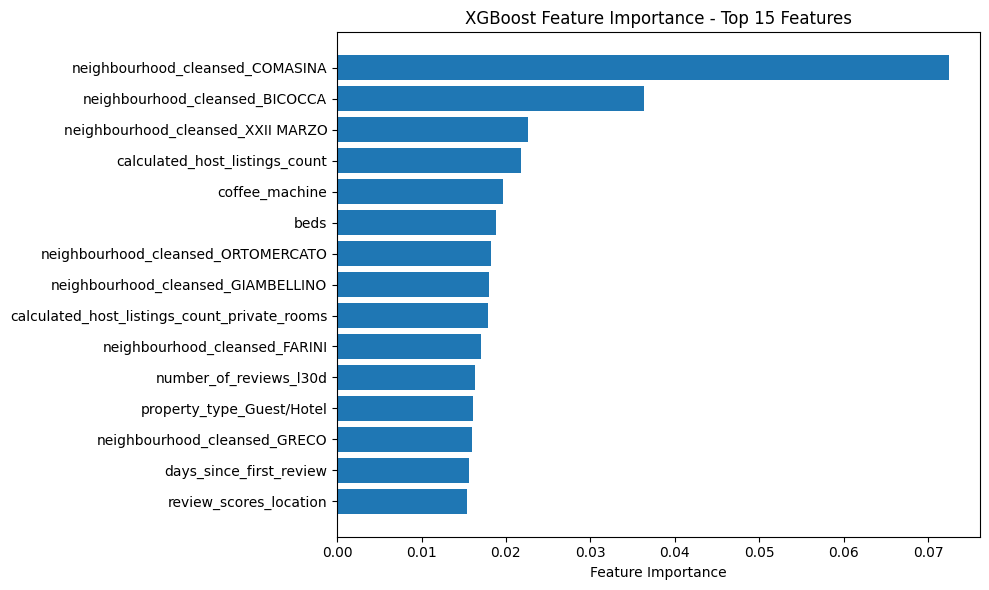


SHAP ANALYSIS
Analyzing 500 predictions with SHAP TreeExplainer...
SHAP values computed: (500, 89)

SHAP Feature Importance Ranking:


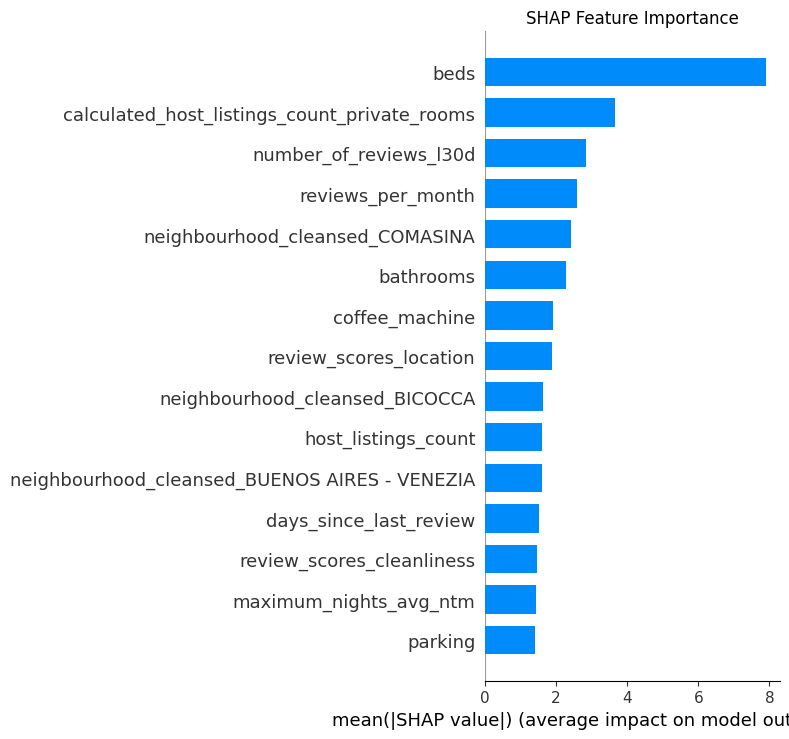


SHAP Impact Direction Analysis:


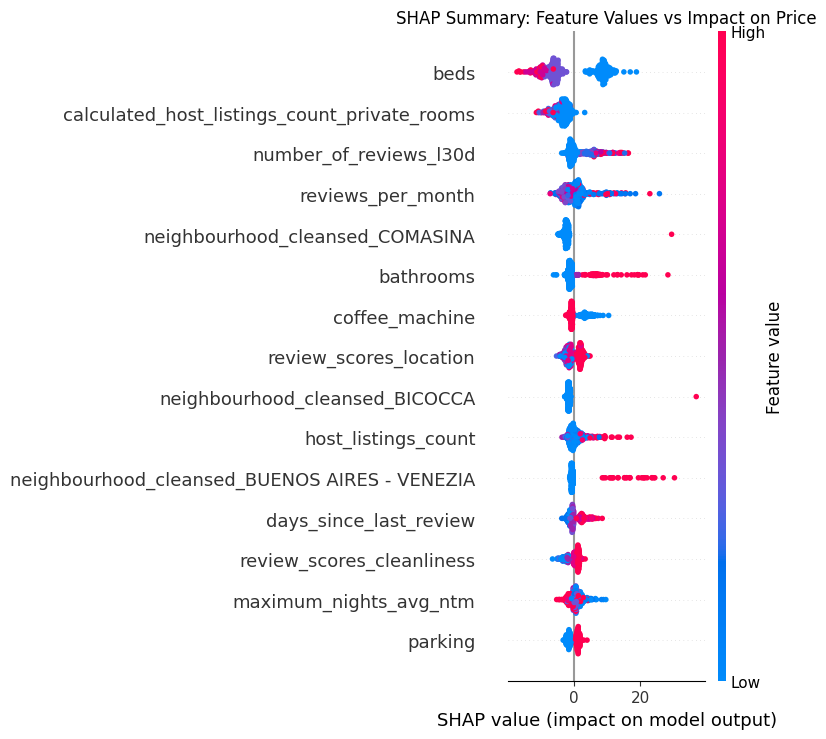


Individual Prediction Explanation:
Waterfall plot error: waterfall() got an unexpected keyword argument 'feature_names'

SHAP Feature Ranking (Top 15):
                                      feature  mean_abs_shap
                                         beds       7.902334
 calculated_host_listings_count_private_rooms       3.658108
                       number_of_reviews_l30d       2.835384
                            reviews_per_month       2.594077
              neighbourhood_cleansed_COMASINA       2.426707
                                    bathrooms       2.277465
                               coffee_machine       1.915637
                       review_scores_location       1.873806
               neighbourhood_cleansed_BICOCCA       1.622714
                          host_listings_count       1.612618
neighbourhood_cleansed_BUENOS AIRES - VENEZIA       1.592175
                       days_since_last_review       1.518264
                    review_scores_cleanliness       1.

In [15]:
# =====================================================
# FEATURE IMPORTANCE AND SHAP ANALYSIS
# =====================================================

%pip install shap

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import shap

# 1. XGBOOST BUILT-IN FEATURE IMPORTANCE
print("XGBOOST FEATURE IMPORTANCE ANALYSIS")
print("=" * 60)

# Extract the XGBoost regressor from the pipeline
xgb_regressor = final_model.named_steps['regressor']
importance = xgb_regressor.feature_importances_

# Create feature importance DataFrame with real names
importance_df = pd.DataFrame({
    'feature': real_feature_names[:len(importance)],
    'importance': importance
}).sort_values('importance', ascending=False)

print("Top 15 Most Important Features:")
print(importance_df.head(15).to_string(index=False))

# Plot feature importance
plt.figure(figsize=(10, 6))
top_15 = importance_df.head(15)
plt.barh(range(len(top_15)), top_15['importance'])
plt.yticks(range(len(top_15)), top_15['feature'])
plt.xlabel('Feature Importance')
plt.title('XGBoost Feature Importance - Top 15 Features')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

# =====================================================
# 2. SHAP ANALYSIS
# =====================================================

print("\nSHAP ANALYSIS")
print("=" * 60)

# Prepare data for SHAP
X_test_transformed = final_model[:-1].transform(X_test)

# Sample for computational efficiency
sample_size = 500
if len(X_test_transformed) > sample_size:
    np.random.seed(42)
    sample_indices = np.random.choice(len(X_test_transformed), sample_size, replace=False)
    X_sample = X_test_transformed[sample_indices]
else:
    X_sample = X_test_transformed
    sample_indices = np.arange(len(X_test_transformed))

print(f"Analyzing {len(X_sample)} predictions with SHAP TreeExplainer...")

# Create SHAP explainer
explainer = shap.TreeExplainer(xgb_regressor)
shap_values = explainer.shap_values(X_sample)

print(f"SHAP values computed: {shap_values.shape}")

# SHAP Feature Importance Bar Plot
print("\nSHAP Feature Importance Ranking:")
plt.figure(figsize=(10, 6))
shap.summary_plot(shap_values, X_sample, 
                  feature_names=real_feature_names[:shap_values.shape[1]],
                  plot_type="bar", max_display=15, show=False)
plt.title("SHAP Feature Importance")
plt.tight_layout()
plt.show()

# SHAP Summary Plot
print("\nSHAP Impact Direction Analysis:")
plt.figure(figsize=(10, 8))
shap.summary_plot(shap_values, X_sample,
                  feature_names=real_feature_names[:shap_values.shape[1]],
                  max_display=15, show=False)
plt.title("SHAP Summary: Feature Values vs Impact on Price")
plt.tight_layout()
plt.show()

# Individual Prediction Explanation
print("\nIndividual Prediction Explanation:")
try:
    shap.waterfall_plot(explainer.expected_value, shap_values[0], X_sample[0],
                       feature_names=real_feature_names[:shap_values.shape[1]],
                       max_display=10)
    
    # Prediction details
    actual_price = np.expm1(y_test.iloc[sample_indices[0]])
    predicted_price = np.expm1(final_model.predict(X_test.iloc[sample_indices[0]:sample_indices[0]+1])[0])
    
    print(f"Actual Price: ${actual_price:.2f}")
    print(f"Predicted Price: ${predicted_price:.2f}")
    print(f"Absolute Error: ${abs(actual_price - predicted_price):.2f}")
    
except Exception as e:
    print(f"Waterfall plot error: {e}")

# SHAP Feature Ranking
mean_abs_shap = np.mean(np.abs(shap_values), axis=0)
shap_ranking = pd.DataFrame({
    'feature': real_feature_names[:len(mean_abs_shap)],
    'mean_abs_shap': mean_abs_shap
}).sort_values('mean_abs_shap', ascending=False)

print("\nSHAP Feature Ranking (Top 15):")
print(shap_ranking.head(15).to_string(index=False))

# =====================================================
# 3. METHODOLOGY COMPARISON
# =====================================================

print("\nMETHODOLOGY COMPARISON")
print("=" * 60)

# Merge importance measures
comparison = pd.merge(
    importance_df.head(15)[['feature', 'importance']].rename(columns={'importance': 'XGBoost_Importance'}),
    shap_ranking.head(15)[['feature', 'mean_abs_shap']].rename(columns={'mean_abs_shap': 'SHAP_Importance'}),
    on='feature',
    how='outer'
).fillna(0)

# Calculate rank correlation
xgb_ranks = comparison['XGBoost_Importance'].rank(ascending=False)
shap_ranks = comparison['SHAP_Importance'].rank(ascending=False)
correlation = xgb_ranks.corr(shap_ranks)

print(f"Rank correlation between XGBoost and SHAP importance: {correlation:.3f}")

if correlation > 0.7:
    print("Assessment: Strong agreement between methods")
elif correlation > 0.5:
    print("Assessment: Moderate agreement between methods")
else:
    print("Assessment: Low agreement - requires further investigation")

# =====================================================
# 4. BUSINESS ANALYSIS
# =====================================================

print("\nBUSINESS ANALYSIS")
print("=" * 60)

# Categorize top features
top_5_features = importance_df.head(5)

print("Top 5 Pricing Drivers:")
for i, (_, row) in enumerate(top_5_features.iterrows(), 1):
    feature_name = row['feature']
    importance_val = row['importance']
    
    # Determine category
    if 'property_type' in feature_name.lower():
        category = "Property Type"
    elif 'neighbourhood' in feature_name.lower():
        category = "Location"
    elif any(word in feature_name.lower() for word in ['accommodates', 'bedrooms', 'bathrooms', 'beds']):
        category = "Size/Capacity"
    elif 'review' in feature_name.lower() or 'rating' in feature_name.lower():
        category = "Reviews"
    elif 'room_type' in feature_name.lower():
        category = "Room Type"
    else:
        category = "Amenities/Other"
    
    print(f"{i}. {category}: {feature_name} (Importance: {importance_val:.4f})")

print("\nKey Findings:")
print("1. Property type is the primary pricing differentiator")
print("2. Location creates significant value premiums")  
print("3. Property size directly correlates with pricing power")
print("4. Review quality affects competitive positioning")

print("\nRecommendations:")
print("1. Optimize property type classification and marketing")
print("2. Leverage location advantages in pricing strategy")
print("3. Consider capacity optimization where feasible")
print("4. Maintain review quality standards")

print(f"\nModel Performance Summary:")
test_r2 = r2_score(y_test, final_model.predict(X_test))
print(f"R-squared: {test_r2:.4f}")
print(f"Explained variance: {test_r2*100:.1f}%")